In [1]:
#신체적 특성을 기반으로 꽃게의 나이 예측하기

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [7]:
train.head()
train.tail()
#viscera weight - 내장 무게 / shell weight - 껍데기 무게

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
74046,74046,F,1.6625,1.2625,0.4375,50.660556,20.680960,10.361742,12.332033,10
74047,74047,I,1.0750,0.8625,0.2750,10.446791,4.323299,2.296310,3.543687,6
74048,74048,F,1.4875,1.2000,0.4125,29.483480,12.303683,7.540967,8.079607,10
74049,74049,I,1.2125,0.9625,0.3125,16.768729,8.972617,2.919999,4.280774,8
74050,74050,I,0.9125,0.6750,0.2000,5.386405,2.055339,1.034757,1.700970,6


## EDA

In [9]:
train.shape

(74051, 10)

In [14]:
for column in train.columns:
    unique_values = len(train[column].unique())
    print(f"{column} : {unique_values} distinct values")

id : 74051 distinct values
Sex : 3 distinct values
Length : 144 distinct values
Diameter : 122 distinct values
Height : 65 distinct values
Weight : 3096 distinct values
Shucked Weight : 1766 distinct values
Viscera Weight : 967 distinct values
Shell Weight : 1048 distinct values
Age : 28 distinct values


In [15]:
train.isnull().sum()

id                0
Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
Age               0
dtype: int64

In [16]:
train.describe()

,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000
mean,37025.000000,1.317460,1.024496,0.348089,23.385217,10.104270,5.058386,6.723870,9.967806
std,21376.826729,0.287757,0.237396,0.092034,12.648153,5.618025,2.792729,3.584372,3.175189
min,0.000000,0.187500,0.137500,0.000000,0.056699,0.028349,0.042524,0.042524,1.000000
25%,18512.500000,1.150000,0.887500,0.300000,13.437663,5.712424,2.863300,3.968930,8.000000
50%,37025.000000,1.375000,1.075000,0.362500,23.799405,9.908150,4.989512,6.931453,10.000000
75%,55537.500000,1.537500,1.200000,0.412500,32.162508,14.033003,6.988152,9.071840,11.000000
max,74050.000000,2.012815,1.612500,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000


In [17]:
test.shape

(49368, 9)

In [18]:
for column in test.columns:
    unique_values = len(test[column].unique())
    print(f"{column} : {unique_values} distinct values")

id : 49368 distinct values
Sex : 3 distinct values
Length : 140 distinct values
Diameter : 122 distinct values
Height : 57 distinct values
Weight : 2948 distinct values
Shucked Weight : 1692 distinct values
Viscera Weight : 938 distinct values
Shell Weight : 987 distinct values


In [25]:
test.info()
#성별의 타입만 object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49368 entries, 0 to 49367
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              49368 non-null  int64  
 1   Sex             49368 non-null  object 
 2   Length          49368 non-null  float64
 3   Diameter        49368 non-null  float64
 4   Height          49368 non-null  float64
 5   Weight          49368 non-null  float64
 6   Shucked Weight  49368 non-null  float64
 7   Viscera Weight  49368 non-null  float64
 8   Shell Weight    49368 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 3.4+ MB


In [19]:
test.isnull().sum()

id                0
Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
dtype: int64

In [20]:
test.describe()

,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
count,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000
mean,98734.500000,1.319795,1.026357,0.348693,23.464627,10.130220,5.072615,6.745876
std,14251.458382,0.286950,0.236593,0.092259,12.641703,5.611779,2.791563,3.575650
min,74051.000000,0.187500,0.137500,0.000000,0.056699,0.028349,0.014175,0.042524
25%,86392.750000,1.162500,0.887500,0.300000,13.536886,5.740774,2.877474,3.968930
50%,98734.500000,1.387500,1.075000,0.362500,23.813580,9.979024,4.989512,6.945627
75%,111076.250000,1.537500,1.200000,0.412500,32.290081,14.047177,7.016501,9.171063
max,123418.000000,2.037500,1.625000,2.825000,80.101512,42.184056,21.545620,28.491248


### 분포도 확인

In [21]:
#id를 제외한 다른 컬럼들의 분포 확인
data = train.copy()
data = data.drop('id', axis=1)

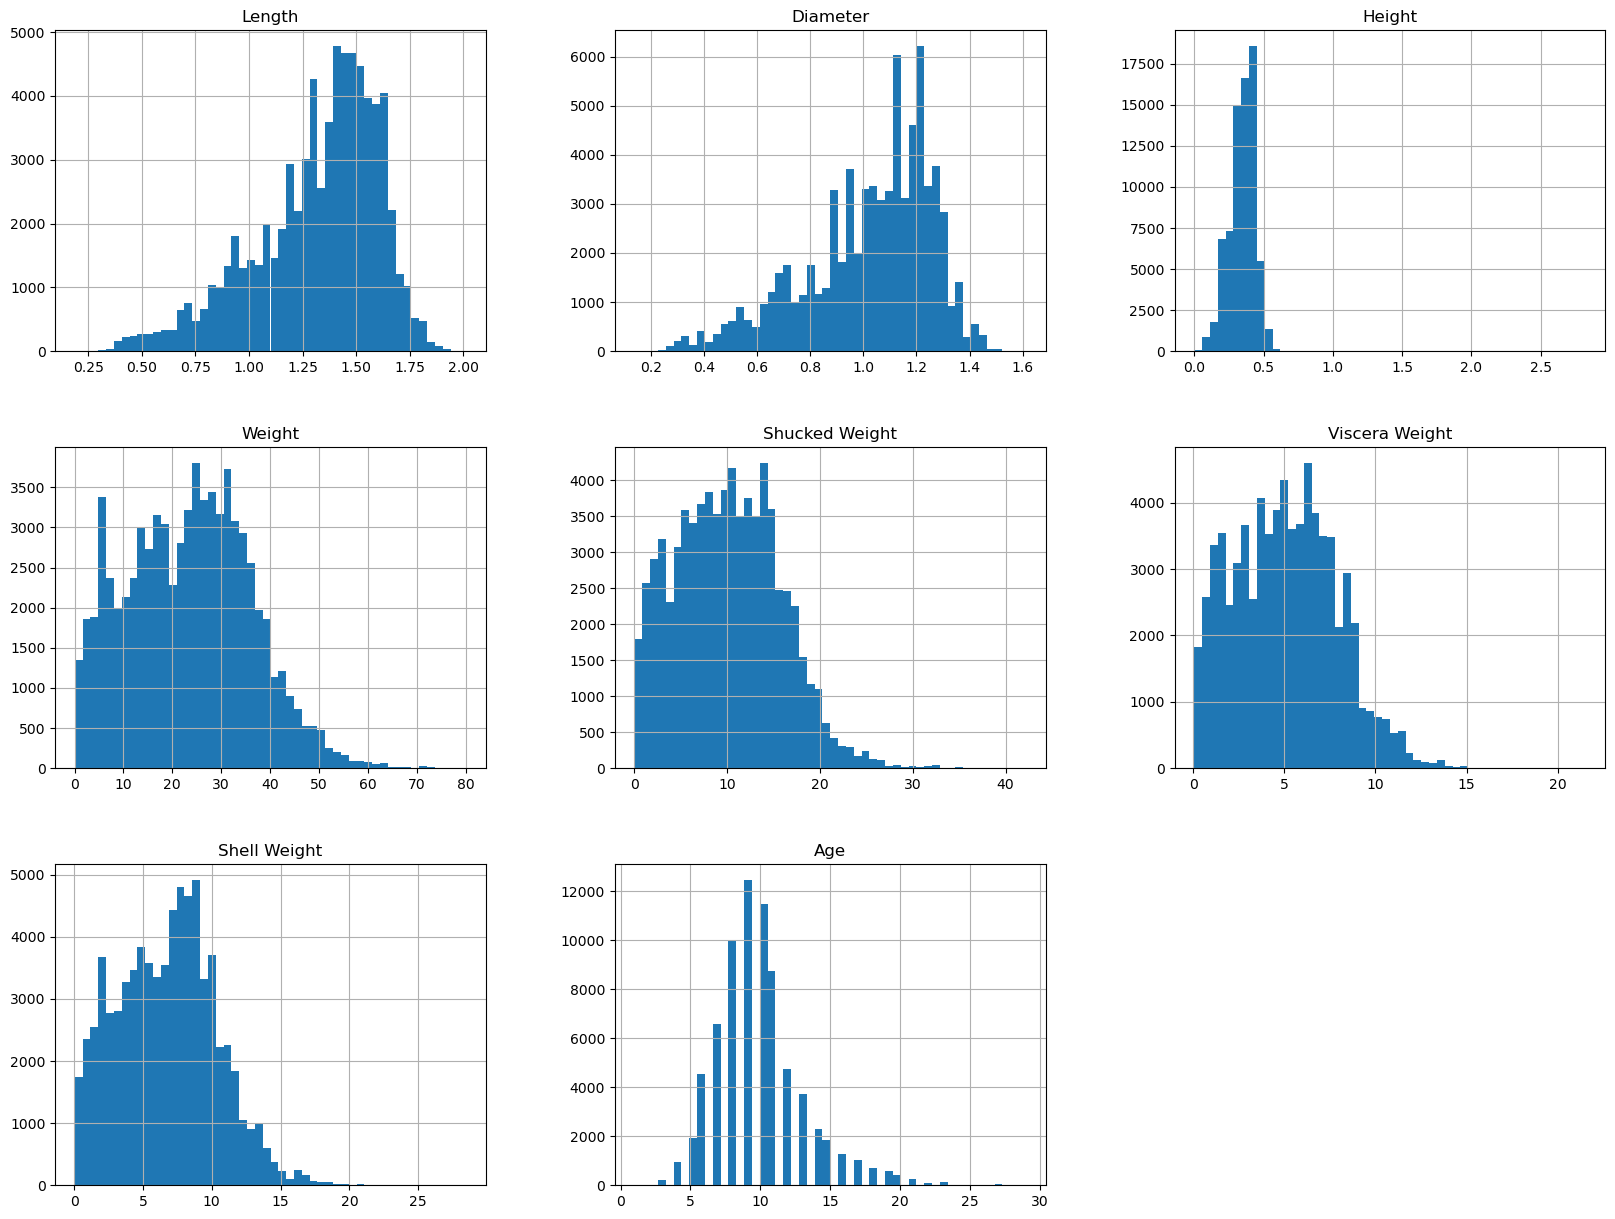

In [24]:
data.hist(bins=50, figsize=(20,15))
plt.show()

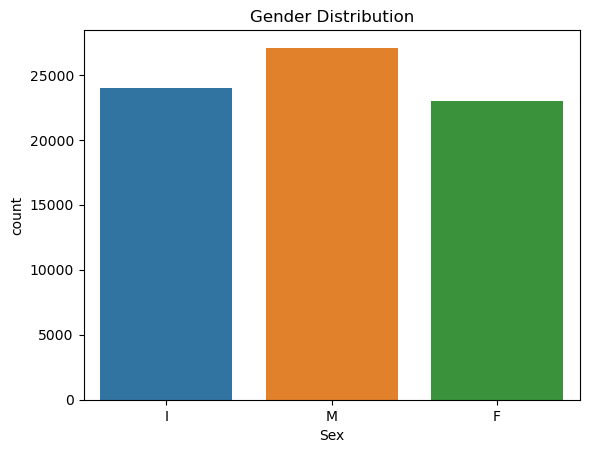

In [27]:
#성별을 object 타입이므로 따로 그래프 그려주기

sns.countplot(x='Sex', data=data)
plt.title('Gender Distribution')
plt.show()

### 요소들 간의 상관관계 확인

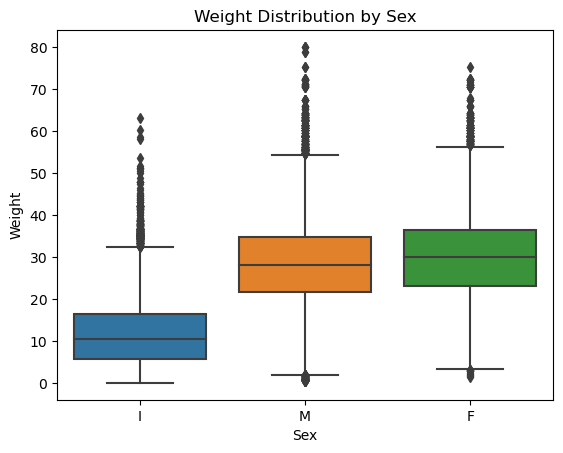

In [28]:
#성별 무게 측정
sns.boxplot(x='Sex', y='Weight', data=train)
plt.title('Weight Distribution by Sex')
plt.show()

In [29]:
#암컷의 무게가 수컷보다 조금 더 높음을 알 수 있다

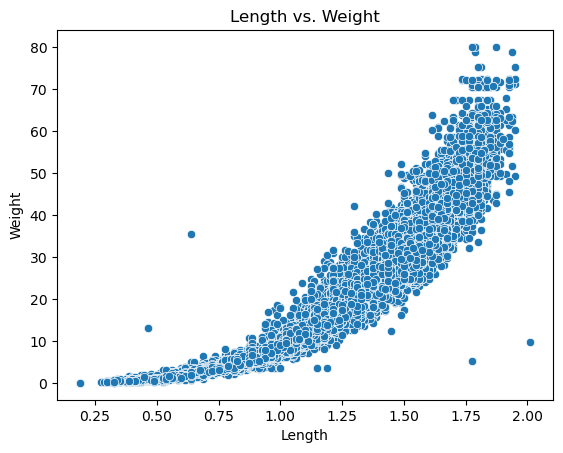

In [34]:
#length와 weight의 상관관계

sns.scatterplot(x='Length', y='Weight', data = train)
plt.title('Length vs. Weight')
plt.show()

In [ ]:
#양의 상관관계 양상을 띈다

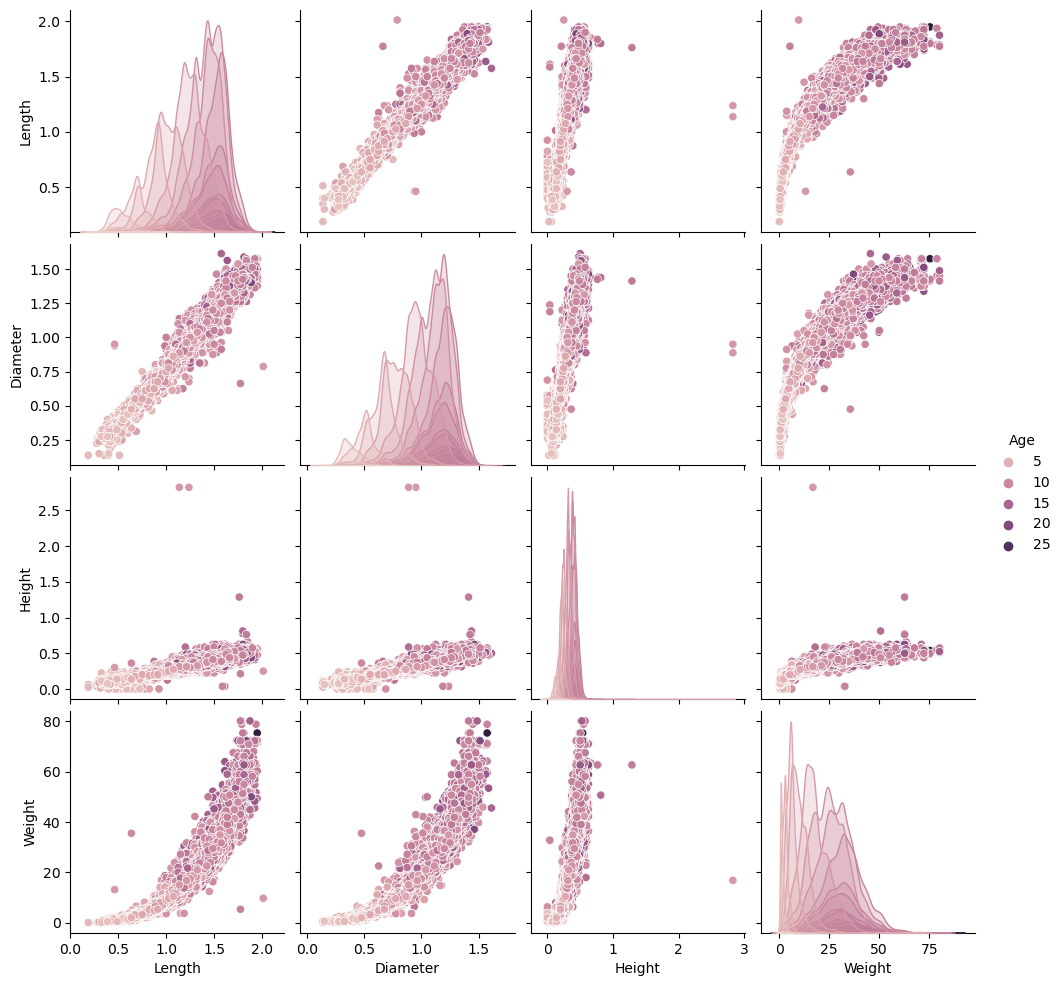

In [30]:
#length, diameter, height, weight간의 상관관계를 age별로 확인

sns.pairplot(train, vars = ['Length', 'Diameter', 'Height', 'Weight'], hue='Age')
plt.show()

In [31]:
#length-weight, diameter-length, diameter-weight 간의 양의 상관관계를 알 수 있고
#연령별 분포를 확인할 수 있다

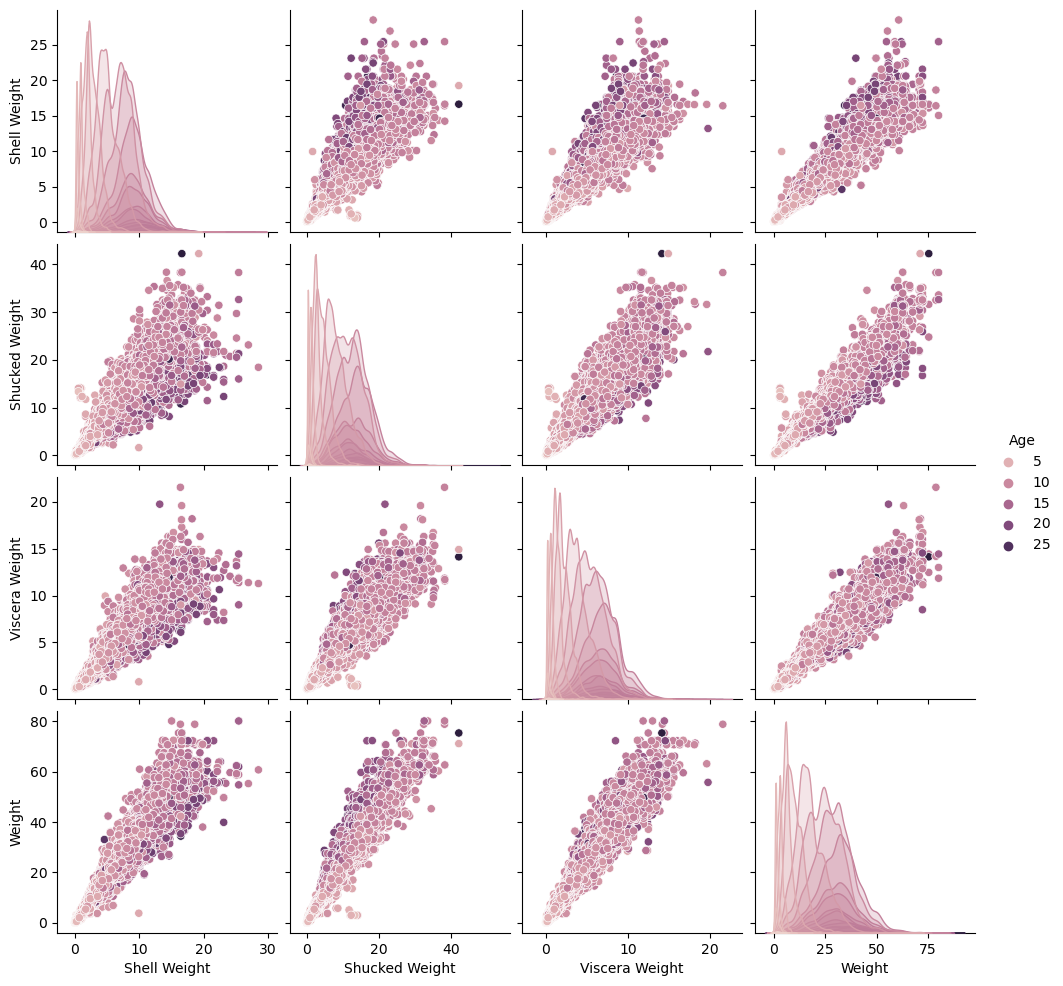

In [32]:
#shell weight, shucked weight, viscera weight, weight간의 상관관계를 age별로 확인

sns.pairplot(train, vars = ['Shell Weight', 'Shucked Weight', 'Viscera Weight', 'Weight'], hue='Age')

In [ ]:
#weight, shell weight, shucked weight, viscera weight 간에는 서로 대부분 양의 상관관계를 띄고 있음
#그러나 좀더 넓은 범위의 산포도를 확인할 수 있음

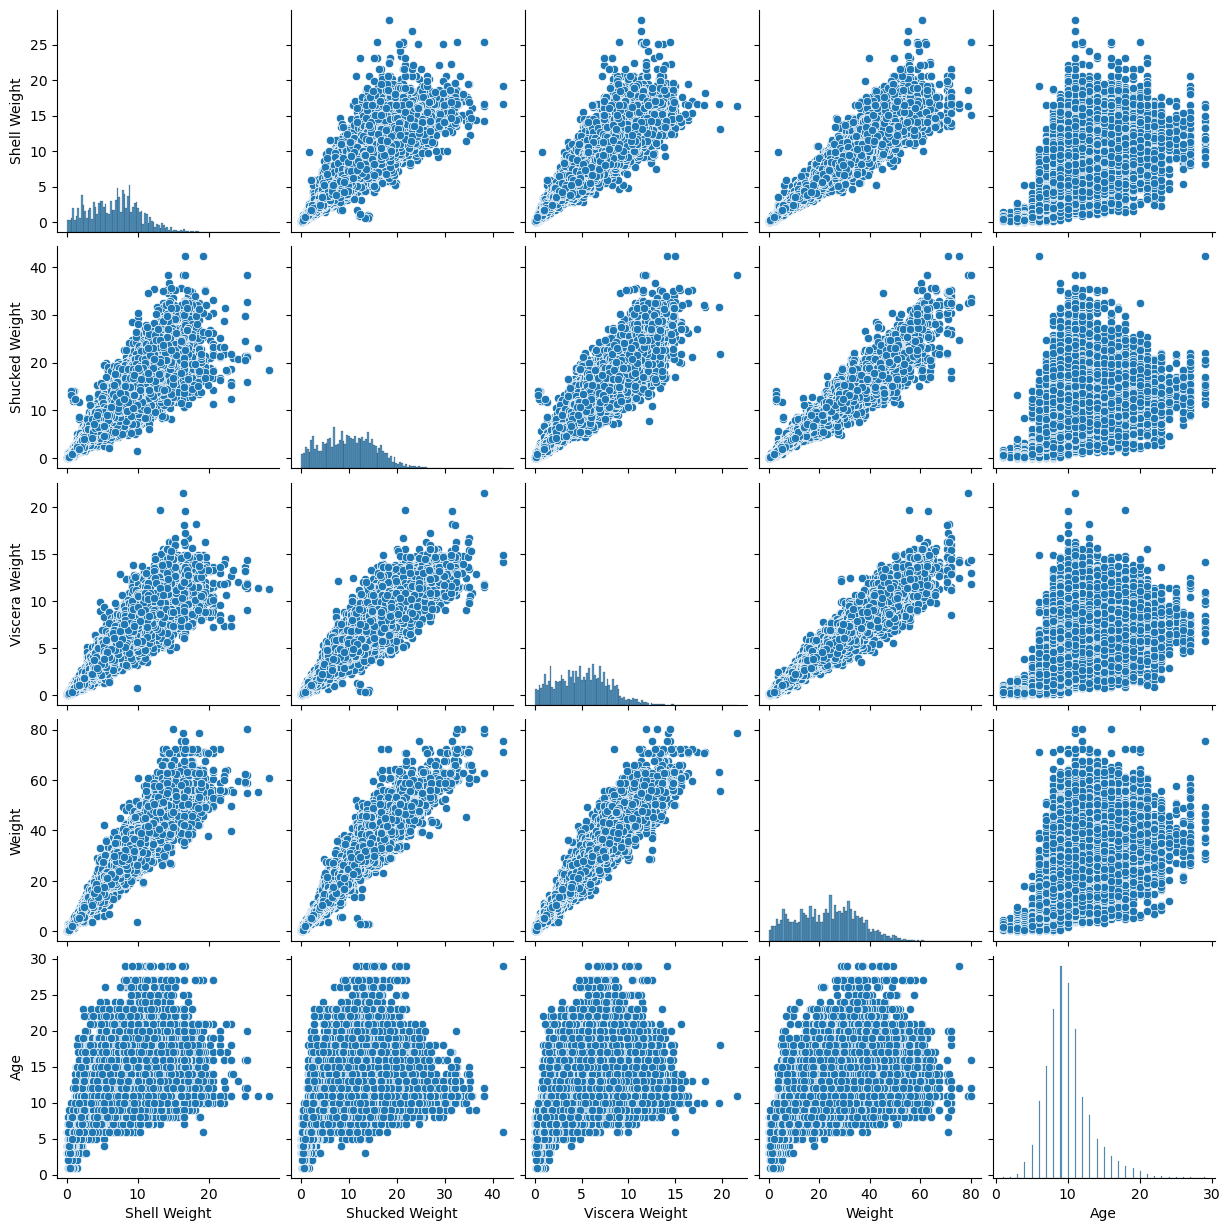

In [33]:
sns.pairplot(train, vars = ['Shell Weight', 'Shucked Weight', 'Viscera Weight', 'Weight', 'Age'])

In [35]:
#age별 특징을 확인하기 위해 그래프 그려봤지만 분포가 전반적으로 되어있어 age별로 어떤 특성을 파악하기는 어려웠다

<AxesSubplot:xlabel='Length', ylabel='Weight'>

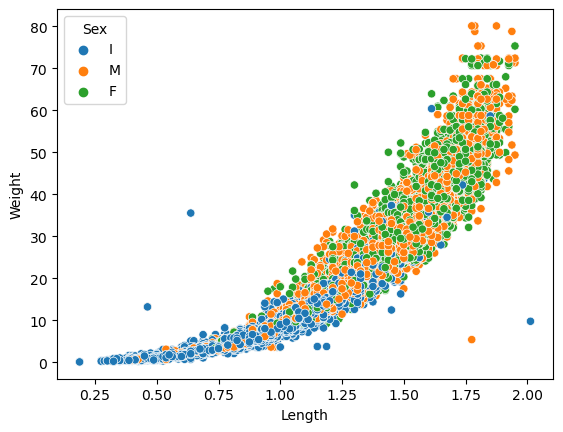

In [36]:
#성별로 length, weight, diameter 확인하기

sns.scatterplot(x='Length', y='Weight', hue='Sex', data=train)

<AxesSubplot:xlabel='Diameter', ylabel='Weight'>

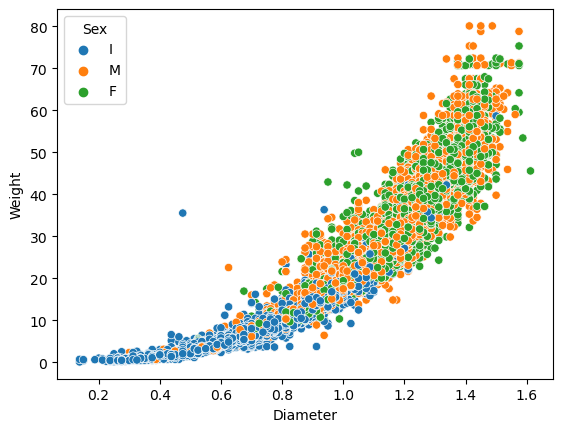

In [37]:
sns.scatterplot(x='Diameter', y='Weight', hue='Sex', data=train)

<AxesSubplot:xlabel='Height', ylabel='Weight'>

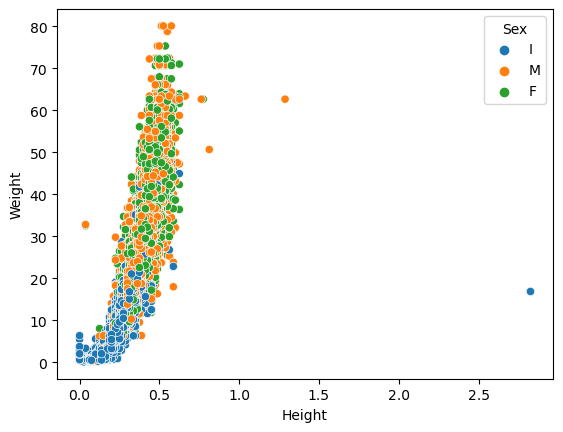

In [38]:
sns.scatterplot(x='Height', y='Weight', hue='Sex', data=train)

In [39]:
#전반적으로 두 요소간의 상관관계를 확인할 수 있지만 성별로 드러나는 뚜렷한 차이는 없다

### Correlation

In [42]:
def perform_one_hot_encoding(train, column_name):
    dummies = pd.get_dummies(train[column_name], prefix=column_name)
    #기존에 있던 열을 드랍시키고 새로 만든 더미를 이어붙이는 방식
    train = pd.concat([train.drop(column_name, axis=1), dummies], axis=1)
    return train

data = perform_one_hot_encoding(data, 'Sex')

#성별은 one hot encoding으로 1 또는 0 으로 표현이 가능하기 때문에 함수를 활용하여 간단하게 인코딩이 가능하다

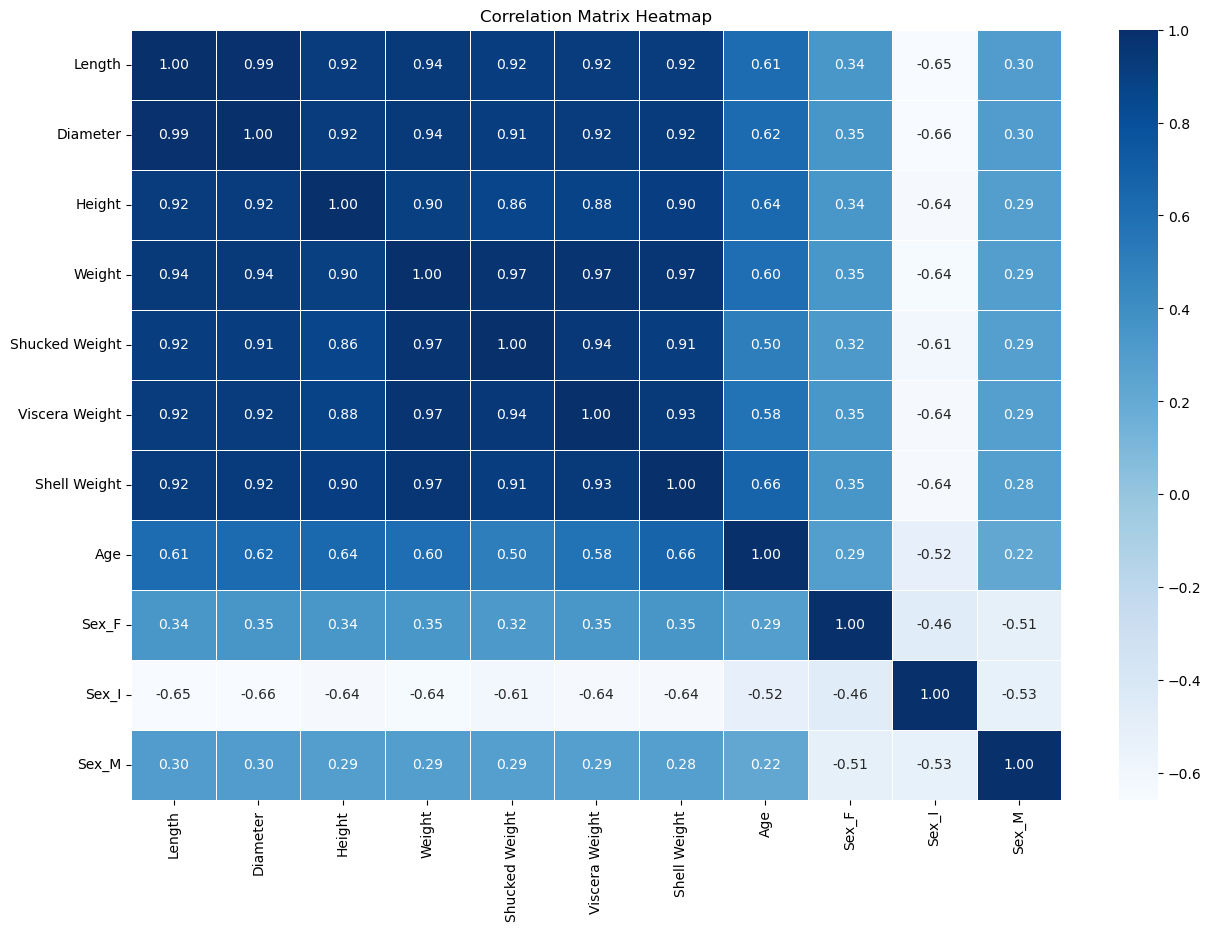

In [50]:
correlation_matrix = data.corr()

plt.figure(figsize=(15,10))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()

In [51]:
#성별로 특정한 무게나 지름 크기에 대한 특징을 가지지는 않고
#연령별로는 어느 정도 무게나 지름 크기에 대한 상관관계를 보인다

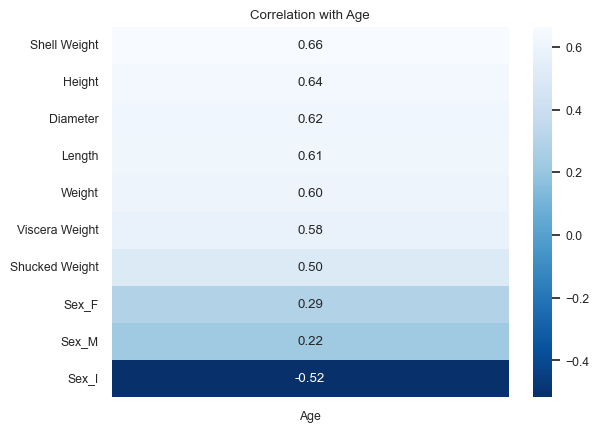

In [61]:
#특정 컬럼을 기준으로만 상관관계를 확인하는 방법

corr = data.corr()
target_corr = corr['Age'].drop('Age')

target_corr_sorted = target_corr.sort_values(ascending=False) #내림차순

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("Blues_r")
sns.heatmap(target_corr_sorted.to_frame(), cmap="Blues_r", annot=True, fmt='.2f')
plt.title('Correlation with Age')
plt.show()

## Prediction

In [63]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, VotingRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [64]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [65]:
#split features
X = train.drop(columns=['id', 'Age'])
y = train['Age']

#split dat into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

test_ids = test['id']
X_test = test.drop(columns=['id'])

# 1.Train data
# ->(training과정에서 사용) 학습을 하기 위한 용도

# 2.Validation data
# ->(training과정에서 사용) 학습을 하는 과정에서 중간평가를 하기 위한 용도 (train data에서 일부를 떼내서 가져온다.)

# 3.Test data
# ->(training과정이 끝난 후 성능평가를 하기 위해 사용) 훈련한 모델을 한번도 보지 못한 데이터를 이용해서 평가를 하기 위한 용도

In [67]:
numeric_features = ['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight']
categorical_features = ['Sex']

preprocessor = ColumnTransformer(
   transformers = [
       ('num', StandardScaler(), numeric_features),
       ('cat', OneHotEncoder(), categorical_features)
   ] 
)
#ColumnTransformer는 처리가 어려운 데이터를 파이프라인 과정에서 사용할 수 있도록 처리하는 과정
#StandardScaler - 평균 0 , 분산 1로 조정
#OneHotEncoder - 카테고리형 변수를 0 또는 1로 인코딩해줌

In [68]:
#define XGBRegressor
xgb_model = xgb.XGBRegressor(random_state=42, objective = 'reg:squarederror')

In [70]:
#create piplines (기계 학습 파이프라인의 핵심은 전체 기계 학습 작업을 다단계 워크플로로 분할하는 것)
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', xgb_model)])

In [71]:
#define parameter grid for XGBoost
xgb_params = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__max_depth': [3, 5, 7],
    'regressor__subsample': [0.5, 0.7, 1.0],
    'regressor__colsample_bytree': [0.6, 0.8, 1.0],
}

#파라미터는 dictionary 형태로 설정

In [72]:
# Randomized search for XGBoost
xgb_random_search = RandomizedSearchCV(xgb_pipeline, xgb_params, n_iter=50, cv=5, verbose=0, n_jobs=1, random_state=42)
xgb_random_search.fit(X_train, y_train)

# Print the best parameters from the randomized search for XGBoost
print(f"Best parameters for XGBoost: {xgb_random_search.best_params_}")

#랜덤 서치는 하이퍼 파라미터 값을 랜덤하게 넣어보고 그중 우수한 값을 보인 하이퍼 파라미터를 활용해 모델을 생성한다는 것
#불필요한 탐색 횟수를 줄인다는 장점이 있다
#그리드 서치 - 전체 조합

Best parameters for XGBoost: {'regressor__subsample': 1.0, 'regressor__n_estimators': 100, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.1, 'regressor__colsample_bytree': 0.6}


In [ ]:
# subsample - 각 트리가 전체 데이터의 100%를 학습했다는 의미
# estimators - XGBoost 모델에서 빌드될 트리의 수 (트리의 수가 많을 수록 더 강력한 모델이 생성되지만 계산 복잡도 증가)
# max_depth - 트리의 최대 깊이
# learning rate - 모델이 학습하는 속도를 제어 (값이 낮을수록 더 많은 트리를 만들어야 더 정확해진다)
# colsample bytree - 각 트리를 빌드하기 위해 샘플링되는 피쳐의 부분을 제어 (전체 형상의 60%가 샘플링된다는 의미)

In [73]:
# Model evaluation using cross-validation (교차 검증)
xgb_cv_scores = cross_val_score(xgb_random_search.best_estimator_, X_train, y_train, cv=5)
print(f"Cross-Validation scores for XGBoost: {xgb_cv_scores}")

#best_estimator_ : 최고 점수를 낸 파라미터를 가진 모형을 추출

Cross-Validation scores for XGBoost: [0.58271211 0.58545696 0.56739169 0.59230129 0.57932332]


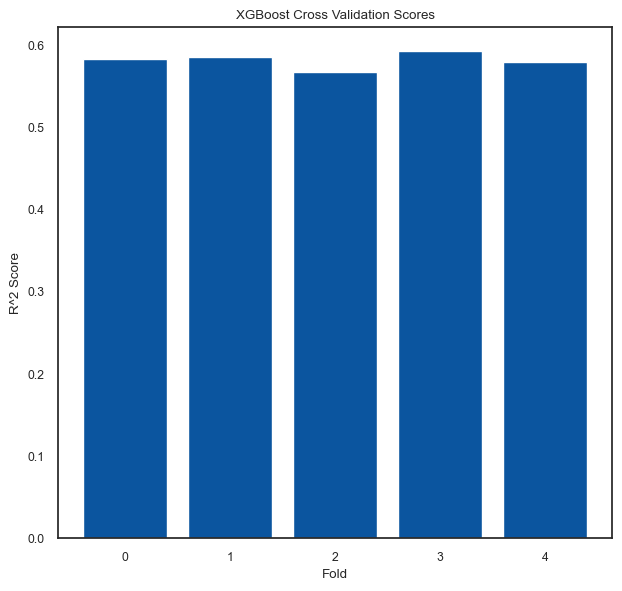

In [74]:
# Plotting cross-validation scores
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(range(len(xgb_cv_scores)), xgb_cv_scores)
plt.xlabel('Fold')
plt.ylabel('R^2 Score')
plt.title('XGBoost Cross Validation Scores')

plt.tight_layout()
plt.show()

In [75]:
# Feature importance for XGBoost
xgb_importances = xgb_random_search.best_estimator_.named_steps['regressor'].feature_importances_

print(f"Feature importances for XGBoost: {xgb_importances}")

#named_steps - 중간 결과 보기 (선택된 변수에 대해서)

Feature importances for XGBoost: [0.02652361 0.01565797 0.17388016 0.20074786 0.07723037 0.01544598
 0.31669217 0.01380962 0.15155342 0.00845878]


In [ ]:
#순서대로 Length, Diameter, Height, Weight, Shucked Weight, Viscera Weight, Shell Weight, Sex_F, Sex_I, Sex_M

#결론적으로 Age에 가장 큰 영향을 끼치는 것은 Shell Weight
#가장 덜 영향을 끼치는 요소는 Sex_M, Viscera Weight, Diameter

In [76]:
# Ensemble learning
voting_regressor = VotingRegressor(estimators=[('xgb', xgb_random_search.best_estimator_)])

# Fit the VotingRegressor to the training data
voting_regressor.fit(X_train, y_train)

# Predict on the validation set and calculate metrics
y_val_pred = voting_regressor.predict(X_val)
print(f'Validation RMSE: {np.sqrt(mean_squared_error(y_val, y_val_pred))}')
print(f'Validation MAE: {mean_absolute_error(y_val, y_val_pred)}')
print(f'Validation R2 Score: {r2_score(y_val, y_val_pred)}')

#Voting은 서로 다른 알고리즘을 가지고, 분류기가 같은 데이터셋을 기반으로 학습되고 결합하는 것
#MSE - 예측값과 실제값의 차이에 대한 제곱을 평균한 것
#MAE - 예측값과 실제값의 차이에 대한 절대값을 평균한 것
#R2 Score - 회귀 모델의 성능에 대한 평가 지표 (=결정계수)

Validation RMSE: 2.0362471464593748
Validation MAE: 1.4067923532830704
Validation R2 Score: 0.5931633972100456


### Apply on Test Data

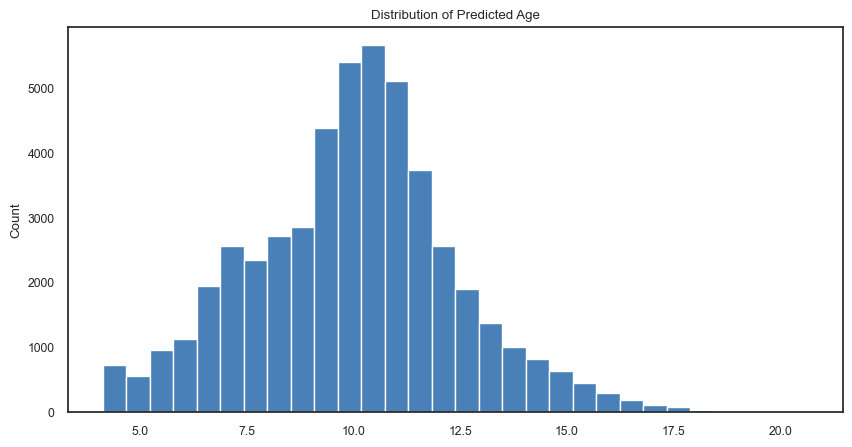

In [77]:
# Predict on the test set
y_test_pred = voting_regressor.predict(X_test)

# Visualize prediction results
plt.figure(figsize=(10, 5))
sns.histplot(y_test_pred, bins=30)
plt.title('Distribution of Predicted Age')
plt.show()

In [78]:
# Prepare final submission dataframe
submission = pd.DataFrame({
    'id': test_ids,
    'Age': y_test_pred
})
print(submission.head())

      id        Age
0  74051   7.475645
1  74052   7.703733
2  74053  10.653482
3  74054   9.387329
4  74055   7.487246
